# SFC analyses of SUVA dataset

Here, the idea is mostly to explore the functional connectivity between the two hemicords

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import os.path

In [2]:
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress=True)

In [3]:
%matplotlib inline

## Import data

### Data structure

_**Note:** Here, only subjects with FD < 0.3mm are kept._

In [83]:
Root='/media/miplab-nas2/Data/SpinalCord/5_Stroke/SUVA/'
Directories={'FuncDir':'/Functional/',
             'SubRoot':'SUVA-TIMES-',
             'TCDir':'TC_native/',
             'OutputDir': Root + 'Analyses/sFC/',
             'LesionDir': Root + 'LesionAnalysis/',
             #'maskNames':['C5_short_gm_LD','C5_short_gm_LV','C5_short_gm_RD','C5_short_gm_RV','C6_short_gm_LD','C6_short_gm_LV','C6_short_gm_RD','C6_short_gm_RV','C7_short_gm_LD','C7_short_gm_LV','C7_short_gm_RD','C7_short_gm_RV','C5toC7_gm_L','C5toC7_gm_R','C5toC7_CST_L','C5toC7_CST_R','C5toC7_short_gm_RV','C5toC7_short_gm_LV','C5toC7_short_gm_RD','C5toC7_short_gm_LD','C5toC7_short_RV','C5toC7_short_LV','C5toC7_short_RD','C5toC7_short_LD'],
             #'maskNames':['C5_short_gm_LV','C5_short_gm_RV','C6_short_gm_LV','C6_short_gm_RV','C7_short_gm_LV','C7_short_gm_RV'],
             #'maskNames':['C5toC7_gm_L','C5toC7_gm_R'],
             #'maskNames':['C5_short_gm_LD','C5_short_gm_LV','C5_short_gm_RD','C5_short_gm_RV','C6_short_gm_LD','C6_short_gm_LV','C6_short_gm_RD','C6_short_gm_RV','C7_short_gm_LD','C7_short_gm_LV','C7_short_gm_RD','C7_short_gm_RV'],
             #'maskNames':['C5toC7_short_gm_RV','C5toC7_short_gm_LV','C5toC7_short_gm_RD','C5toC7_short_gm_LD','C5toC7_short_RV','C5toC7_short_LV','C5toC7_short_RD','C5toC7_short_LD'],
            'maskNames':['C5toC7_short_gm_RV','C5toC7_short_gm_LV','C5toC7_short_gm_RD','C5toC7_short_gm_LD'],
            'keep_only_T3':'True',
            'list_patients':{
                '001':{'sess':['T4'],'side':'R','keep_T3':'False'},
                '002':{'sess':['T3','T4'],'side':'R','keep_T3':'True'},
                '003':{'sess':['T3','T4'],'side':'L','keep_T3':'True'},
                '004':{'sess':['T3'],'side':'L','keep_T3':'False'},
                '005':{'sess':['T2','T3'],'side':'R','keep_T3':'True'},
                '006':{'sess':['T3'],'side':'L','keep_T3':'True'},
                '007':{'sess':['T3'],'side':'R','keep_T3':'True'},
                '008':{'sess':['T2','T3'],'side':'L','keep_T3':'True'},
                '009':{'sess':['T4'],'side':'L','keep_T3':'False'},
                '010':{'sess':['T3','T4'],'side':'R','keep_T3':'True'},
                '011':{'sess':['T2','T4'],'side':'R','keep_T3':'False'},
                '014':{'sess':['T3','T4'],'side':'R','keep_T3':'True'},
                '016':{'sess':['T2','T3'],'side':'R','keep_T3':'True'},
                '017':{'sess':['T3'],'side':'L','keep_T3':'False'},
                '018':{'sess':['T2','T3'],'side':'L','keep_T3':'False'},
                '019':{'sess':['T2'],'side':'R','keep_T3':'False'},
                '020':{'sess':['T4'],'side':'L','keep_T3':'False'},
                '021':{'sess':['T3'],'side':'L','keep_T3':'True'},
                '022':{'sess':['T2','T3'],'side':'R','keep_T3':'True'},
                '023':{'sess':['T3'],'side':'R','keep_T3':'True'},
                '024':{'sess':['T3'],'side':'R','keep_T3':'False'},
                '025':{'sess':['T3'],'side':'R','keep_T3':'True'},
                '026':{'sess':['T2','T3'],'side':'L','keep_T3':'True'},
                '027':{'sess':['T3'],'side':'L','keep_T3':'False'},
                '028':{'sess':['T3'],'side':'R','keep_T3':'True'},
                '031':{'sess':['T3'],'side':'L','keep_T3':'True'}},
             'acute_only': True # True if we take only acute part of the lesions (for the subjects with old lesions)
} 

### Read subject data

#### Timecourses

In [84]:
subs = []
sessions = []
masks = []
tc_mask = np.empty((239,0))
for sub in Directories['list_patients']: # Loop through all subjects
    for session in Directories['list_patients'][sub]['sess']: # Loop through sessions for a particular subject        
        if (Directories['keep_only_T3'] == 'True' and Directories['list_patients'][sub]['keep_T3'] == 'True' and session == 'T3') or Directories['keep_only_T3'] == 'False':
            SubDir = Root + Directories['SubRoot'] + sub + '/' + session + Directories['FuncDir']
            for mask in Directories['maskNames']: # Loop through masks
                subs.append(sub)
                sessions.append(session)
                masks.append(mask)
                tc_mask = np.append(tc_mask,np.array(pd.read_csv(SubDir + Directories['TCDir'] + Directories['SubRoot'] + sub + '_' + session + '_' + mask + '_bp.txt')),axis=1)       

colnames = pd.MultiIndex.from_arrays([subs,sessions,masks], names=["subjects","sessions","masks"])
tcs_df = pd.DataFrame(tc_mask,columns=colnames)

In [42]:
# Note: to access a particular element in df: tcs_df.xs(("T4","C5_short_gm_LD"),level=("sessions","masks"),axis=1)

#### Lesions

**_Using FSL atlas (binarized at 70%)_**

In [71]:
subs = []
sessions = []
weighted_load_L = []
weighted_load_R = []
lesion_vol = []

# Function for CST load computation
def compute_weighted_load(lesion,side):
    ''' Computes CST load (weighted, using binarized atlas), see https://onlinelibrary.wiley.com/doi/10.1002/ana.24510
    
        Parameter
        ----------
        lesion : 3D array containing the mask of the overlap
        side: left (0) or right (1) hemicord

        Return
        -------
        load : weighted load
    '''
    # ATLAS
    if side == 0:
        template = nib.load(Directories['LesionDir'] + 'Atlas/FSL_CST_L_resized_bin_thr70.nii.gz')
    elif side == 1:
        template = nib.load(Directories['LesionDir'] + 'Atlas/FSL_CST_R_resized_bin_thr70.nii.gz')
    template_np = template.get_fdata()   
    sum_slice = template_np.sum(axis=(0,1)) # Sum of voxels per slice (atlas)
    with np.errstate(all='ignore'):
        ratio_slice = sum_slice.max() / sum_slice # Maximum number of voxels
        
    # LESION
    sum_slice_lesion = lesion.sum(axis=(0,1)) # Sum of voxel per slice (lesion)
    with np.errstate(all='ignore'):
        weighted_overlap = np.nansum(sum_slice_lesion * ratio_slice)
    return weighted_overlap

# Compute load for each subject / session
for sub in Directories['list_patients']: # Loop through all subjects
    for session in Directories['list_patients'][sub]['sess']: # Loop through sessions for a particular subject
        if (Directories['keep_only_T3'] == 'True' and Directories['list_patients'][sub]['keep_T3'] == 'True' and session == 'T3') or Directories['keep_only_T3'] == 'False':
            subs.append(sub)
            sessions.append(session)
            tmp_load = np.zeros((2,1))
            for sideix,side in enumerate(['L','R']):
                if Directories['acute_only']==True and os.path.isfile(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-acute_only-overlap_FSL_CST_' + side + '.nii.gz'):
                    lesion_overlap = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-acute_only-overlap_FSL_CST_' + side + '.nii.gz')
                else:
                    lesion_overlap = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-overlap_FSL_CST_' + side + '.nii.gz')
                lesion_overlap_np = lesion_overlap.get_fdata()
                if side == 'L':
                    weighted_load_L.append(compute_weighted_load(lesion_overlap_np,sideix))
                elif side =='R':
                    weighted_load_R.append(compute_weighted_load(lesion_overlap_np,sideix))

            # Add also total volume of lesion
            if Directories['acute_only']==True and os.path.isfile(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-acute_only-overlap_FSL_CST_' + side + '.nii.gz'):
                lesion = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-lesion_acute_only.nii')
            else:
                lesion = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-lesion.nii')
            lesion_np = lesion.get_fdata()
            lesion_vol.append(np.sum(lesion_np))   
            del tmp_load
                
colnames = ["sub","sess","CST_L", "CST_R", "vol"]
lesions_df = pd.DataFrame(list(zip(subs,sessions,weighted_load_L,weighted_load_R,lesion_vol)),columns=colnames)

In [78]:
lesions_df

,sub,sess,CST_L,CST_R,vol
0,002,T3,0.000000,37.492105,153.0
1,003,T3,378.224805,0.000000,583.0
2,005,T3,0.000000,0.000000,7336.0
3,006,T3,183.473253,0.000000,821.0
4,007,T3,0.000000,0.000000,1449.0
5,008,T3,268.873440,0.000000,305.0
6,010,T3,0.000000,0.000000,621.0
7,014,T3,0.000000,0.000000,3645.0
8,016,T3,0.000000,8.970100,15344.0
9,021,T3,0.000000,0.000000,3020.0


## Correlation analyses

### Compute correlations

In [85]:
corr_all = np.empty((len(Directories['maskNames'])**2,0)) # One value for each correlation type (i.e., between two masks)
subs = [] # For the column names
sessions = []
masks1 = []
masks2 = []
for sub in Directories['list_patients']:
    for session in Directories['list_patients'][sub]['sess']: # Loop through sessions for a particular subject
        if (Directories['keep_only_T3'] == 'True' and Directories['list_patients'][sub]['keep_T3'] == 'True' and session == 'T3') or Directories['keep_only_T3'] == 'False':
            subs.append(sub)
            sessions.append(session)
            tmp_corr = np.zeros((len(Directories['maskNames'])**2,1))
            ix = 0
            for mask1ix,mask1 in enumerate(Directories['maskNames']):
                for mask2ix,mask2 in enumerate(Directories['maskNames']):
                        tmp_corr[ix]=np.corrcoef(tcs_df.xs((sub,session,mask1),level=("subjects","sessions","masks"),axis=1),tcs_df.xs((sub,session,mask2),level=("subjects","sessions","masks"),axis=1),rowvar=False)[1,0]
                        masks1.append(mask1)
                        masks2.append(mask2)
                        ix+=1
            corr_all=np.append(corr_all,tmp_corr,axis=1)            
colnames = pd.MultiIndex.from_arrays([subs,sessions], names=["subjects","sessions"])
indnames = pd.MultiIndex.from_arrays([masks1[0:len(Directories['maskNames'])**2],masks2[0:len(Directories['maskNames'])**2]], names=["mask1","mask2"])
corrs_df = pd.DataFrame(corr_all,index=indnames,columns=colnames)

### Plot correlation matrix for each time point

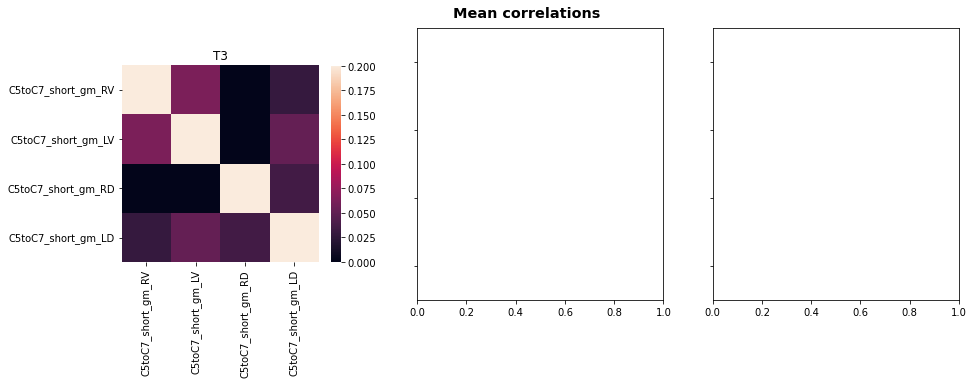

In [86]:
# First, we identify the unique time points present in the data and sort them
sessnames = sorted(corrs_df.columns.get_level_values(level="sessions").unique(), key=lambda x: int(x[-1]))
# Then, we compute the average confusion matrix for each timepoint
mean_corr = np.zeros((len(sessnames),len(Directories['maskNames']),len(Directories['maskNames'])))
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('Mean correlations',y=0.94,fontsize='x-large',weight="bold");
for sessix,sess in enumerate(sessnames):
    mean_corr[sessix,:,:] = np.reshape(np.array(corrs_df.xs(sess,level="sessions",axis=1)).mean(axis=1), (len(Directories['maskNames']), len(Directories['maskNames'])))
    sns.heatmap(mean_corr[sessix,:,:],ax=axes[sessix],xticklabels=Directories['maskNames'],yticklabels=Directories['maskNames'],vmin=0,vmax=0.2,square=True,cbar_kws={"shrink": 0.72})
    axes[sessix].set_title(sess)

### Evaluate link between CST load and interhemicord FC

In [37]:
lesions_df

,sub,sess,CST_L,CST_R,vol
0,002,T3,58.526738,37.492105,153.0
1,003,T3,0.000000,0.000000,583.0
2,005,T3,0.000000,0.000000,7336.0
3,006,T3,0.000000,0.000000,821.0
4,007,T3,0.000000,0.000000,1449.0
5,008,T3,0.000000,0.000000,305.0
6,010,T3,0.000000,0.000000,621.0
7,014,T3,0.000000,0.000000,3645.0
8,016,T3,8.812381,8.970100,15344.0
9,021,T3,0.000000,0.000000,3020.0


In [67]:
lesions_df

,sub,sess,CST_L,CST_R,vol
0,002,T3,0.000000,37.492105,153.0
1,003,T3,378.224805,0.000000,583.0
2,005,T3,0.000000,0.000000,7336.0
3,006,T3,183.473253,0.000000,821.0
4,007,T3,0.000000,0.000000,1449.0
5,008,T3,268.873440,0.000000,305.0
6,010,T3,0.000000,0.000000,18484.0
7,014,T3,0.000000,0.000000,32568.0
8,016,T3,0.000000,8.970100,15344.0
9,021,T3,0.000000,0.000000,6685.0


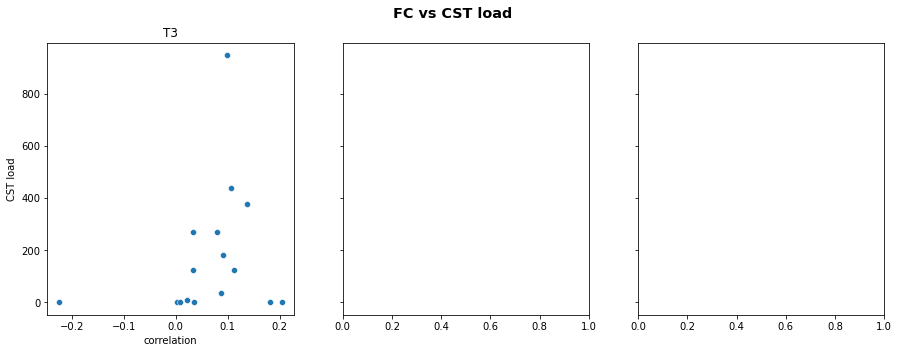

In [89]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('FC vs CST load',fontsize='x-large',weight="bold");
for sessix,sess in enumerate(sessnames):
    sns.scatterplot(x=np.squeeze(corrs_df.xs(sess,level="sessions",axis=1).xs(('C5toC7_short_gm_LV','C5toC7_short_gm_RV'),level=("mask1","mask2"),axis=0).values),y=lesions_df['CST_L'].values + lesions_df['CST_R'].values,ax=axes[sessix])
    axes[sessix].set_title(sess)
plt.setp(axes[0], xlabel='correlation');
plt.setp(axes[0], ylabel='CST load');

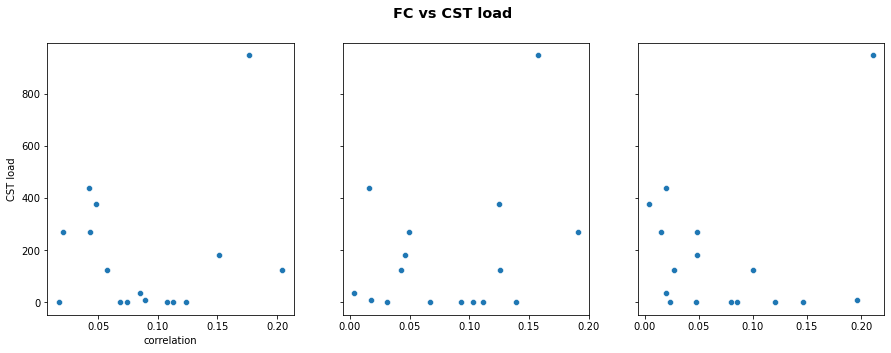

In [82]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('FC vs CST load',fontsize='x-large',weight="bold");
sns.scatterplot(x=np.absolute(np.squeeze(corrs_df.xs(('C5_short_gm_LD','C5_short_gm_RV'),level=("mask1","mask2"),axis=0).values)),y=(lesions_df.loc[lesions_df['sess']=='T3','CST_L'].values)+(lesions_df.loc[lesions_df['sess']=='T3','CST_R'].values),ax=axes[0])
sns.scatterplot(x=np.absolute(np.squeeze(corrs_df.xs(('C6_short_gm_LD','C6_short_gm_RD'),level=("mask1","mask2"),axis=0).values)),y=(lesions_df.loc[lesions_df['sess']=='T3','CST_L'].values)+(lesions_df.loc[lesions_df['sess']=='T3','CST_R'].values),ax=axes[1])
sns.scatterplot(x=np.absolute(np.squeeze(corrs_df.xs(('C7_short_gm_LD','C7_short_gm_RD'),level=("mask1","mask2"),axis=0).values)),y=(lesions_df.loc[lesions_df['sess']=='T3','CST_L'].values)+(lesions_df.loc[lesions_df['sess']=='T3','CST_R'].values),ax=axes[2])
plt.setp(axes[0], xlabel='correlation');
plt.setp(axes[0], ylabel='CST load');

## Archives

## **_Method 2: Using atlas provided by Elvira (binarized)_**

In [14]:
subs = []
sessions = []
weighted_load = np.empty((2,0))

# Function for CST load computation
def compute_weighted_load(lesion):
    ''' Computes CST load (weighted, using binarized atlas), see https://onlinelibrary.wiley.com/doi/10.1002/ana.24510
    
        Parameter
        ----------
        lesion : 3D array containing the mask of the overlap

        Return
        -------
        load : weighted load
    '''
    # ATLAS
    template = nib.load(Directories['LesionDir'] + 'Atlas/Cortico_Spinal_Tract_L.nii')
    template_np = template.get_fdata()    
    sum_slice = template_np.sum(axis=(0,1)) # Sum of voxels per slice (atlas)
    with np.errstate(all='ignore'):
        ratio_slice = sum_slice.max() / sum_slice # Maximum number of voxels
        
    # LESION
    sum_slice_lesion = lesion.sum(axis=(0,1)) # Sum of voxel per slice (lesion)
    with np.errstate(all='ignore'):
        weighted_overlap = np.nansum(sum_slice_lesion * ratio_slice)
    return weighted_overlap

# Compute load for each subject / session
for sub in Directories['list_subjects']: # Loop through all subjects
    for session in Directories['list_subjects'][sub]: # Loop through sessions for a particular subject
        subs.append(sub)
        sessions.append(session)
        tmp_load = np.zeros((2,1))
        for sideix,side in enumerate(['L','R']):
            if Directories['acute_only']==True and os.path.isfile(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-acute_only-overlap_CST_' + side + '.nii.gz'):
                lesion = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-acute_only-overlap_CST_' + side + '.nii.gz')
            else:
                lesion = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-overlap_CST_' + side + '.nii.gz')
            lesion_np = lesion.get_fdata()
            tmp_load[sideix,-1] = compute_weighted_load(lesion_np)
        weighted_load = np.append(weighted_load,tmp_load,axis=1)
        del tmp_load
colnames = pd.MultiIndex.from_arrays([subs,sessions], names=["subjects","sessions"])
lesions_df = pd.DataFrame(weighted_load,index=['Lesion CST L','Lesion CST R'],columns=colnames)

KeyError: 'list_subjects'

**_Method 3: Using FSL atlas (probabilistic)_**
To finish!

In [ ]:
subs = []
sessions = []
weighted_load = np.empty((2,0))

def compute_ratio(atlas,sliceix,intensity)
    ''' Computes the weighting ratio for a given slice and a given voxel intensity.
    
        Parameter
        ----------
        atlas : 3D array containing the atlas region
        sliceix : indices of the slice of interest
        intensity : intensity of the voxel of interest

        Return
        -------
        ratio : weighting ratio
    '''
    # First, binarize atlas at desired intensity
    atlas_bin = (atlas >= intensity).astype(np.float_)
    atlas_sum = atlas_bin.sum(axis=(0,1)) # Sum of voxels per slice (atlas) 

    ratio = atlas_sum.max()/atlas_sum[sliceix] # Max nb / nb in slice
    
    return ratio

# Function for CST load computation
def compute_weighted_load(lesion):
    ''' Computes CST load (weighted, using probabilistic atlas), see https://doi.org/10.1161/STROKEAHA.109.577023
    
        Parameter
        ----------
        lesion : 3D array containing the mask of the overlap

        Return
        -------
        load : weighted load
    '''
    # ATLAS
    template_L = nib.load(Directories['LesionDir'] + 'Atlas/FSL_CST_L_resized.nii')
    template_L_np = template_L.get_fdata()
    template_R = nib.load(Directories['LesionDir'] + 'Atlas/FSL_CST_R_resized.nii')
    template_R_np = template_R.get_fdata()
    
    sum_slice = template_np.sum(axis=(0,1)) # Sum of voxels per slice (atlas)
    with np.errstate(all='ignore'):
        ratio_slice = sum_slice.max() / sum_slice # Maximum number of voxels
        
    # LESION
    sum_slice_lesion = lesion.sum(axis=(0,1)) # Sum of voxel per slice (lesion)
    with np.errstate(all='ignore'):
        weighted_overlap = np.nansum(sum_slice_lesion * ratio_slice)
    return weighted_overlap

# Compute load for each subject / session
for sub in Directories['list_subjects']: # Loop through all subjects
    for session in Directories['list_subjects'][sub]: # Loop through sessions for a particular subject
        subs.append(sub)
        sessions.append(session)
        tmp_load = np.zeros((2,1))
        for sideix,side in enumerate(['L','R']):
            if Directories['acute_only']==True and os.path.isfile(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-acute_only-overlap_CST_' + side + '.nii.gz'):
                lesion = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-acute_only-overlap_CST_' + side + '.nii.gz')
            else:
                lesion = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot'] + sub + '-' + session + '-overlap_CST_' + side + '.nii.gz')
            lesion_np = lesion.get_fdata()
            tmp_load[sideix,-1] = compute_weighted_load(lesion_np)
        weighted_load = np.append(weighted_load,tmp_load,axis=1)
        del tmp_load
colnames = pd.MultiIndex.from_arrays([subs,sessions], names=["subjects","sessions"])
lesions_df = pd.DataFrame(weighted_load,index=['Lesion CST L','Lesion CST R'],columns=colnames)